In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from fydyc_dataset import FydycDataset
import os

dataset = FydycDataset(csv_file='fydyc/风力.csv')
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
train_dataloader = DataLoader(train_dataset, batch_size=10000, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=10000, shuffle=True, num_workers=2)

In [4]:
import torch
import torch.nn as nn

class PolynomialRegression(nn.Module):
    def __init__(self, degree):
        super(PolynomialRegression, self).__init__()
        self.degree = degree
        # 计算两个变量的多项式特征数量（包括交叉项和常数项）
        num_features = (degree + 1) * (degree + 2) // 2
        self.linear = nn.Linear(num_features, 1)
    
    def forward(self, x):
        # x应该是一个二维张量，其中x[:, 0]是x1，x[:, 1]是x2
        poly_features = []
        for i in range(self.degree + 1):
            for j in range(self.degree + 1 - i):
                # 通过使用unsqueeze方法增加一个维度，确保每个特征都是二维的
                poly_feature = (x[:, 0] ** i * x[:, 1] ** j).unsqueeze(1)
                poly_features.append(poly_feature)
        poly_features = torch.cat(poly_features, dim=1)
        return self.linear(poly_features)

# 示例使用
degree = 2  # 举例使用二次多项式
model = PolynomialRegression(degree)

# 假设我们有一些输入数据x，其中包含两个特征
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)

# 获取模型的预测结果
output = model(x)
print(output)


tensor([[-2.1304],
        [-9.0974]], grad_fn=<AddmmBackward0>)


 10%|████▍                                       | 1/10 [00:37<05:40, 37.81s/it]

Train loss at epoch 0: 0.7009741266568502
Valid loss at epoch 0: 0.7046554684638977


 20%|████████▊                                   | 2/10 [01:13<04:53, 36.64s/it]

Train loss at epoch 1: 0.6855266491572062
Valid loss at epoch 1: 0.6864597797393799


 30%|█████████████▏                              | 3/10 [01:45<04:02, 34.62s/it]

Train loss at epoch 2: 0.6760692000389099
Valid loss at epoch 2: 0.6685358285903931


 40%|█████████████████▌                          | 4/10 [02:18<03:23, 33.92s/it]

Train loss at epoch 3: 0.6502597530682882
Valid loss at epoch 3: 0.6508997082710266


 50%|██████████████████████                      | 5/10 [02:52<02:49, 33.83s/it]

Train loss at epoch 4: 0.6412186423937479
Valid loss at epoch 4: 0.6335716843605042


 60%|██████████████████████████▍                 | 6/10 [03:26<02:16, 34.06s/it]

Train loss at epoch 5: 0.6113669872283936
Valid loss at epoch 5: 0.6165552139282227


 70%|██████████████████████████████▊             | 7/10 [03:59<01:40, 33.45s/it]

Train loss at epoch 6: 0.5974701245625814
Valid loss at epoch 6: 0.5998827815055847


 80%|███████████████████████████████████▏        | 8/10 [04:32<01:06, 33.45s/it]

Train loss at epoch 7: 0.5838013291358948
Valid loss at epoch 7: 0.583540141582489


 90%|███████████████████████████████████████▌    | 9/10 [05:06<00:33, 33.72s/it]

Train loss at epoch 8: 0.568905254205068
Valid loss at epoch 8: 0.5675180554389954


100%|███████████████████████████████████████████| 10/10 [05:41<00:00, 34.11s/it]

Train loss at epoch 9: 0.5569898883501688
Valid loss at epoch 9: 0.5518209338188171


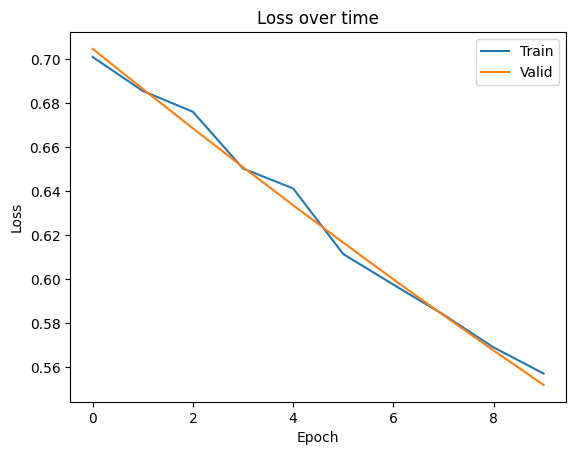

In [5]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam


criterion = nn.MSELoss()
optimizer = Adam(model.parameters())

train_losses = []  # 保存每个周期的训练损失
valid_losses = []  # 保存每个周期的验证损失
for epoch in tqdm(range(10)):
    # 训练阶段
    model.train()  # 设置模型为训练模式
    epoch_train_losses = []  # 保存每个批次的训练损失
    for inputs, labels in train_dataloader:
        # inputs和labels已经是正确的形状，不需要再次调整
        # inputs = inputs.to(device)
        # labels = labels.to(device)

        optimizer.zero_grad()
        output = model(inputs)  # 确保模型接受两个特征的输入
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

    epoch_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(epoch_train_loss)

    # 验证阶段
    model.eval()  # 设置模型为评估模式
    epoch_valid_losses = []
    with torch.no_grad():
        for inputs, labels in valid_dataloader:
  
            # inputs = inputs.to(device)
            # labels = labels.to(device)

            output = model(inputs)
            loss = criterion(output, labels)
            epoch_valid_losses.append(loss.item())

    epoch_valid_loss = sum(epoch_valid_losses) / len(epoch_valid_losses)
    valid_losses.append(epoch_valid_loss)

    print(f"Train loss at epoch {epoch}: {epoch_train_loss}")
    print(f"Valid loss at epoch {epoch}: {epoch_valid_loss}")

# 绘制训练损失和验证损失
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.legend()
plt.show()


In [6]:
torch.save(model.state_dict(), 'fydyc/10epoch-风力-多项式回归-2次.pth')
degree = 2  # 二次多项式
modeltest = PolynomialRegression(degree)
# modeltest = nn.DataParallel(modeltest) 
modeltest.load_state_dict(torch.load('fydyc/10epoch-风力-多项式回归-2次.pth'))

<All keys matched successfully>

In [17]:
modeltest.load_state_dict(torch.load('fydyc/10epoch-风力-多项式回归-2次.pth'))
model.eval()

# 假设我们有一些输入数据x，其中包含两个特征
test_value = torch.tensor([[0.8, 0.1]])

# 使用模型进行预测
with torch.no_grad():  # 确保不计算梯度，以节省计算资源
    prediction = model(test_value)

print(f"Prediction for input value {test_value}: {prediction.item()}")

Prediction for input value tensor([[0.8000, 0.1000]]): -0.16311457753181458


In [1]:
import numpy as np
real_value = np.array([[0,1]])  # 假设你的预测值是10
normalized_value = dataset.scaler_features.transform(real_value)
input_tensor = torch.from_numpy(normalized_value).float()
input_tensor = input_tensor.view(1, -1)  # 确保其形状与模型输入的形状相匹配
model.eval()  # 将模型设置为评估模式
with torch.no_grad():  # 不需要计算梯度
    output_tensor = model(input_tensor)
output_value = output_tensor.numpy()  # 将输出张量转换为 numpy 数组
predicted_value = dataset.scaler_labels.inverse_transform(output_value)
print(predicted_value)  # 打印预测值


NameError: name 'dataset' is not defined